## Results of Host Prediction
### Dataset: All viruses, all proteins, without duplicates (~19K)


**Models**: 

***Pretraining: Masked Language Model using Transformer Encoder***
Dataset: UniRef90 Viridae Sequences

***Fine-tuning: Host Prediction using FFN - 2 layers***
Dataset: all viruses, mammals+aves, all hosts, all proteins, without duplicates and single hosts (19K)

**Positional Embedding**: Sin-Cos

**Maximum Sequence Length**: 1366

**Classification**: Multi-class

**\# classes**: 9

**\# train samples** = 14,633

**\# validation samples** = 1,829

**\# test samples** = 1,830

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../..']

In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from src.utils import utils, evaluation_utils, visualization_utils

In [3]:
itr_col = "itr"
experiment_col = "experiment"
y_true_col = "y_true"
human_col = "Human"

FIGURE_CONFIG = {
    "figsize":(10, 10),
    "xtick.labelsize": 12,
    "ytick.labelsize": 12    
}


def plot_auprc(auprc_df, metadata, model_name):
    # sort by median
    sorted_median_auprc_df = auprc_df.groupby("class")["auprc"].median().sort_values(ascending=False)
    visualization_utils.pre_plot_config(FIGURE_CONFIG)
    
    ax = sns.boxplot(data=auprc_df, x="class", y="auprc", order=sorted_median_auprc_df.index)
    
    ax.set_ylim(0, 1)
    ax.set_xticklabels([metadata[t.get_text()] for t in ax.get_xticklabels()])
    ax.set_title(f"Model = {model_name}")
    plt.tight_layout()
    plt.xticks(rotation=-90)
    plt.show()
        
def auprc_analysis(output_filepath, model_name):
    df = pd.read_csv(output_filepath, index_col=0)
    print(f"Read output size = {df.shape}")
    cols = df.columns
    non_human_cols = list(set(cols) - set([itr_col, experiment_col, y_true_col, human_col]))
    print(f"NonHuman cols = {non_human_cols}")
    itrs = df[itr_col].unique()
    
    auprc = []
    pr_curves = []
    for itr in itrs:
        df_itr = df[df[itr_col] == itr]
        pr_curves_df, auprcs_df = evaluation_utils.compute_class_auprc(df_itr, y_pred_columns=non_human_cols + [human_col], y_true_col=y_true_col)
        pr_curves_df[itr_col] = itr
        auprcs_df[itr_col] = itr
        auprc.append(auprcs_df)
        pr_curves.append(pr_curves_df)

    auprc_df = pd.concat(auprc, ignore_index=True)
    pr_curves_df = pd.concat(pr_curves, ignore_index=True)
    
    metadata = utils.compute_class_distribution(df_itr, y_true_col, format=True)
    # Remove Others class
    metadata.pop("Others")
    auprc_df = auprc_df.loc[auprc_df["class"] != "Others"]
    
    plot_auprc(auprc_df, metadata, model_name)
    FIGURE_CONFIG["figsize"] = (12, 8)
    visualization_utils.curve_plot(pr_curves_df, x_col="recall", y_col="precision",
                                   color_group_col="class", style_group_col=None,
                                   output_file_path=None, metadata=metadata, figure_config=FIGURE_CONFIG)
    

### Fine Tuning: Pretrained Transformer Encoder + FFN 2L

Read output size = (9550, 11)
NonHuman cols = ['Cattle', 'Wood mouse', 'Others', 'Lesser bandicoot rat', 'Red junglefowl', 'Horse', 'Goat', 'Desert warthog']


<Figure size 640x480 with 0 Axes>

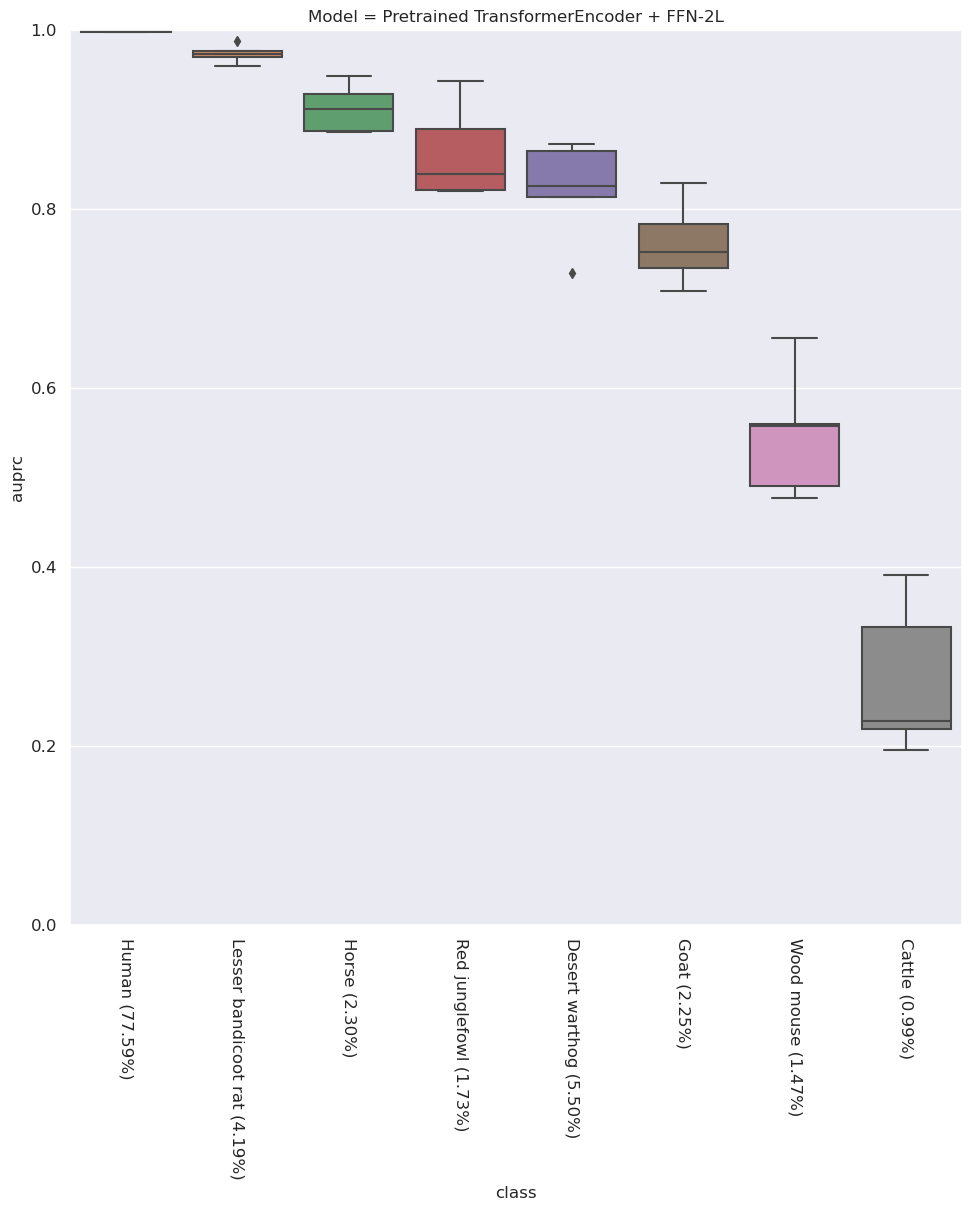

<Figure size 640x480 with 0 Axes>

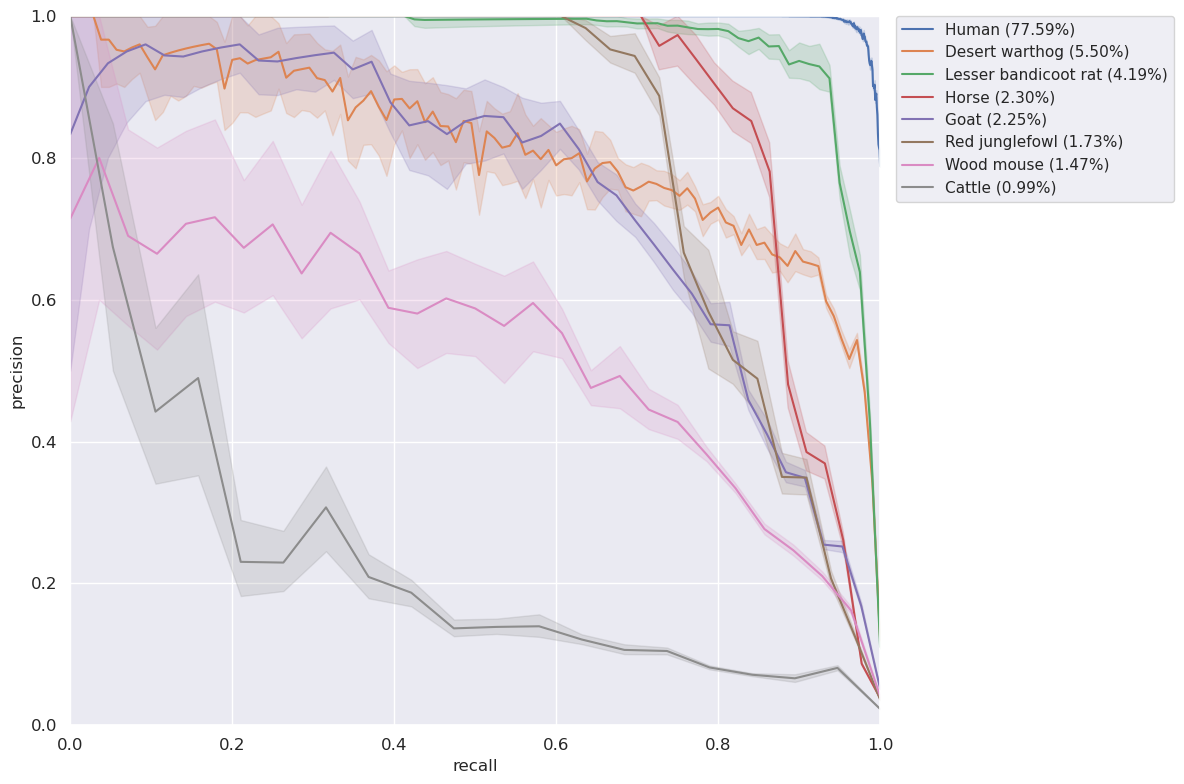

In [4]:
output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..","output/raw/uniref90/20231115/fine_tuning/host_prediction/mlm_transformer_encoder-l_6-h_8-lr1e-4_uniref90viridae_msl1366_host_prediction_fnn_2l_lr1e-4_output.csv")
auprc_analysis(output_filepath, "Pretrained TransformerEncoder + FFN-2L")